# Example Arbor

Example utilizing the `LFPykit` module for predictions of
current dipole moment from a dendritic stick model set up in Arbor (https://github.com/arbor-sim/arbor).
The passive stick receives sinusoid synaptic current input at its terminal
segment.

In [1]:
%matplotlib inline

In [2]:
#!pip install git+https://github.com/espenhgn/arbor@sinsyn#egg=arbor  # adds sinsyn mechanism

In [3]:
# import modules
import numpy as np
import arbor
import lfpykit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

In [4]:
class demo_recipe (arbor.recipe):
    def __init__(self, cell):
        super().__init__()
     
        self.the_cell = cell
        self.vprobe_id = (0, 0)
        self.iprobe_id = (0, 1)
       
    def num_cells(self):
        return 1

    def num_sources(self, gid):
        return 0

    def cell_kind(self, gid):
        return arbor.cell_kind.cable

    def cell_description(self, gid):
        return self.the_cell

    def get_probes(self, gid):
        return [
            arbor.cable_probe_membrane_voltage_cell(),
            arbor.cable_probe_total_current_cell()
        ]

# define morphology
tree = arbor.segment_tree()
tree.append(arbor.mnpos, arbor.mpoint(0, 0, 0, 1), arbor.mpoint(0, 0, 200, 1), tag=1)

# define relative locations (segment midpoints)
nseg = 41
locations = (np.arange(nseg) + 0.5) / nseg

# create cell and set properties
cell = arbor.cable_cell(tree, arbor.label_dict())
cell.set_properties(Vm=-65)  # initial membrane potential (mV)
cell.set_properties(rL=1000)  # axial conductivity (ohm-cm)?
cell.set_properties(cm=1E-2)  # membrane capacitance (F/m2)? should be equal 1 uF/cm2

# number of CVs per branch
cell.compartments_per_branch(nseg)

# set passive mechanism
pas = arbor.mechanism('pas')
pas.set('g', 0.0001)  # leak conductivity (S/cm2)
pas.set('e', -65)  # leak reversal potential (mV)
cell.paint('(all)', pas)

# set sinusoid input current at end point
sinsyn = arbor.mechanism('sinsyn')
sinsyn.set('dur', 1E8)  # stimulation duration (ms)
sinsyn.set('pkamp', 0.001)  # stimulation amplitude (nA)
sinsyn.set('freq', 100)  # stimulation frequency (Hz)
cell.place('(location 0 {})'.format(locations[-1]), sinsyn)

# instantiate recipe with cell
recipe = demo_recipe(cell)

# instantiate simulation and set up sampling on probes
context = arbor.context()
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)
schedule = arbor.regular_schedule(0.1)
v_handle = sim.sample(recipe.vprobe_id, schedule, arbor.sampling_policy.exact)
i_handle = sim.sample(recipe.iprobe_id, schedule, arbor.sampling_policy.exact)

# run simulation for 500 ms of simulated activity and collect results.
sim.run(tfinal=500)

# extract time, V_m and I_m for each compartment
V_m_samples, V_m_meta = sim.samples(v_handle)[0]
I_m_samples, I_m_meta = sim.samples(i_handle)[0]

# note: the cables comprising the metadata for each probe
# should be the same, as well as the reported sample times.
assert V_m_meta==I_m_meta
assert (V_m_samples[:, 0]==I_m_samples[:, 0]).all()

time = V_m_samples[:, 0]
V_m = V_m_samples[:, 1:].T
I_m = I_m_samples[:, 1:].T

In [5]:
# mock up segment geometry data (can't access directly via Arbor yet)
cell_geometry = lfpykit.CellGeometry(x=np.zeros((nseg, 2)),
                                     y=np.zeros((nseg, 2)),
                                     z=np.array(list(zip(np.linspace(0, 200, nseg + 1)[:-1], 
                                                         np.linspace(0, 200, nseg + 1)[1:]))),
                                     d=np.ones((nseg, 2)) * 2.)

In [6]:
# membrane voltages, transmemrbane current and corresponding times
cell_geometry.V_m = V_m  # mV
cell_geometry.I_m = I_m  # nA
cell_geometry.time = time # ms

In [7]:
# compute current dipole moment
cdm = lfpykit.CurrentDipoleMoment(cell=cell_geometry)
M = cdm.get_transformation_matrix()
P = M @ cell_geometry.I_m  # µm*nA

In [8]:
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw colorbar without resizing the axes object to make room
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

Text(0.5, 0, '$t$ (ms)')

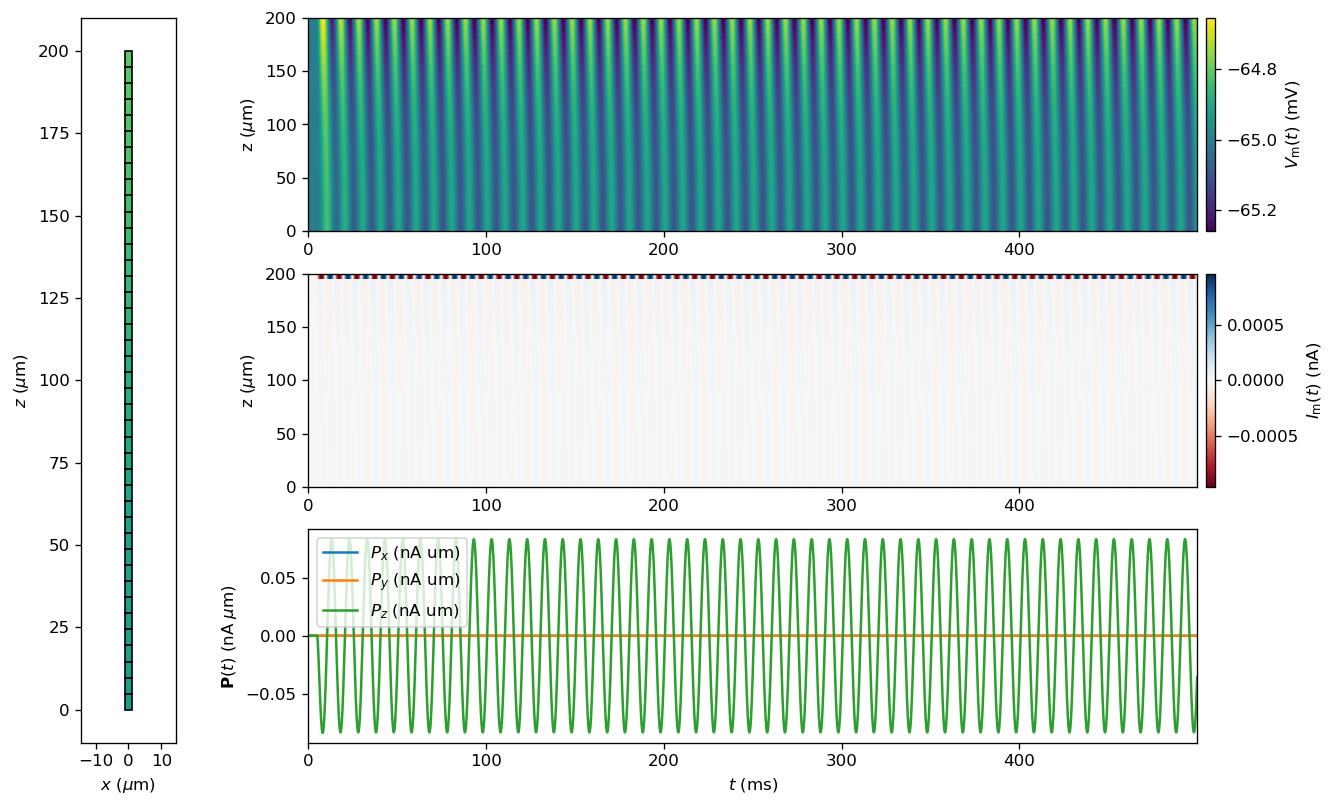

In [9]:
fig = plt.figure(figsize=(12, 8), dpi=120)
gs = GridSpec(3, 10)
# morphology
ax0 = fig.add_subplot(gs[:, 0])
norm = plt.Normalize(vmin=cell_geometry.V_m.min(), vmax=cell_geometry.V_m.max())
for z, d, v in zip(cell_geometry.z, cell_geometry.d.mean(axis=-1), cell_geometry.V_m[:, -1]):
    ax0.add_patch(plt.Rectangle((-d / 2, z[0]), d, z[1] - z[0],
                                ec='k', fc=plt.cm.viridis(norm(v))))
ax0.axis(ax0.axis('equal'))
ax0.set_xlabel(r'$x$ ($\mu$m)')
ax0.set_ylabel(r'$z$ ($\mu$m)')

# membrane voltage
ax1 = fig.add_subplot(gs[0, 2:])
im1 = ax1.pcolormesh(cell_geometry.time, cell_geometry.z.mean(axis=-1), cell_geometry.V_m,
                     shading='auto', norm=norm)
ax1.set_ylabel(r'z ($\mu$m)')
cb = colorbar(fig, ax1, im1)
cb.set_label(r'$V_\mathrm{m}(t)$ (mV)')

# membrane current
ax2 = fig.add_subplot(gs[1, 2:], sharex=ax1, sharey=ax1)
im2 = ax2.pcolormesh(cell_geometry.time, cell_geometry.z.mean(axis=-1), cell_geometry.I_m,
                     cmap='RdBu', shading='auto')
ax2.set_ylabel(r'z ($\mu$m)')
cb = colorbar(fig, ax2, im2)
cb.set_label(r'$I_\mathrm{m}(t)$ (nA)')

# current dipole moment
ax3 = fig.add_subplot(gs[2, 2:], sharex=ax1)
ax3.plot(cell_geometry.time, P.T)
ax3.legend([r'$P_x$ (nA um)', r'$P_y$ (nA um)', r'$P_z$ (nA um)'])
ax3.set_ylabel(r'$\mathbf{P}(t)$ (nA $\mu$m)')
ax3.set_xlabel('$t$ (ms)')